In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
import torchvision.transforms as transforms

import numpy as np
from PIL import Image


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle =True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle =True, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [4]:
image , label = train_data[0]
image.size()

torch.Size([3, 32, 32])

In [5]:
class_names = ['plane','cars','bird','cat','deer','dog','frog','horse','ship','truck']


In [6]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 12,
        kernel_size = 5
    )  #the 3 is taken from the image.size, we need 12x12 as output channel!
    self.pool = nn.MaxPool2d(kernel_size = 2 , stride = 2) #(2,2)
    self.conv2 = nn.Conv2d(
        in_channels = 12,
        out_channels = 24,
        kernel_size = 5
        )            #nxt layer becomes = ([24,5,5])
    self.fc1 = nn.Linear(in_features = 24*5*5, out_features = 120)  #flatterning it up!
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 10) #10 is must ie 10 classes


  def forward(self,x):
    x =self.pool(functional.relu(self.conv1(x))) # we used ReLu to reduce linearity
    x =self.pool(functional.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = functional.relu(self.fc1(x))
    x = functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Conv2d:
After the conv layer we nned to know the current shape of the image
  to do that we need to, ((Size-Kernel)//Stride+1)
  Here the stride is the no of pikels our kernel moves one time!
  ([3,32,32]) -> ([12,28,28])

Maxpool2d:
  after maxpool we get with current size/stride
  ([12,28,28]) -> ([12,14,14])

In [7]:
net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9)


In [9]:
for epoch in range(8):
  print(f"Training epoch:{epoch}...")
  running_loss = 0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Loss:{running_loss/len(train_loader):.4f}")

Training epoch:0...
Loss:0.7426
Training epoch:1...
Loss:0.7039
Training epoch:2...
Loss:0.6726
Training epoch:3...
Loss:0.6455
Training epoch:4...
Loss:0.6173
Training epoch:5...
Loss:0.6095
Training epoch:6...
Loss:0.5906
Training epoch:7...
Loss:0.5725


Now as the mmodel is trained we need to export and save it , but we dont need the entire model...so we need to save only the weight and bias so we can reuse it!

In [10]:
torch.save(net.state_dict(),'trained_net.pth')

In [11]:
net = NeuralNet()
net.load_state_dict(torch.load('trained_net.pth'))


<All keys matched successfully>

In [12]:
correct = 0
total = 0
net.eval()

with torch.no_grad(): # to avoid Gradient calc since we arent training...
  for data in test_loader:
    images, labels = data
    outputs = net(images) #our neural network applied to the images
    _, predicted = torch.max(outputs.data, 1)  #onw thing with highest activation ie the label
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
#how many are classifed correctlyy!!

accuracy = 100*correct/total
print(f"Accuracy:{accuracy}%")

Accuracy:66.16%


Here we might get lower accuracy as we gave low epoch...increase it !


Actual label: cars


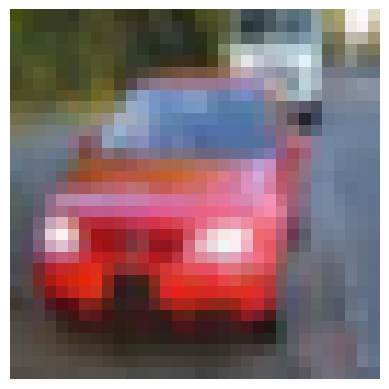

Predicted label: cars


In [14]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a random index
random_index = random.randint(0, len(test_data) - 1)

# Get the image and label
image, label = test_data[random_index]

# Display the image
print("Actual label:", class_names[label])
imshow(image)

# Prepare image for model (add batch dimension)
image_tensor = image.unsqueeze(0)  # Shape: [1, 3, 32, 32]

# Set model to evaluation mode
net.eval()

# Predict
with torch.no_grad():
    output = net(image_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print("Predicted label:", predicted_class)


This CNN isnt accurate enough...might need to increase the epoch to 5 or something...!

need to look into this!
Notes: Possible Improvements for the CIFAR-10 Classifier

Use data augmentation (like random flips or crops) to improve generalization.

Train for more epochs (e.g., 50–100) to allow the model to learn better.

Replace SGD with Adam optimizer for faster and more stable convergence.

Add regularization techniques such as Dropout and Batch Normalization to prevent overfitting.

Use GPU for faster training if available.

Visualize misclassified images to understand where the model is going wrong.

Use pretrained models (transfer learning) like ResNet, VGG, or MobileNet for better performance.

Track training and validation accuracy/loss using graphs for better debugging.

Save and load the trained model for reuse without retraining.

Evaluate the model using a confusion matrix and classification report for a deeper performance analysis.